# Interactive simulation

This notebook is only for designing experiments. Not bulk runs.

In [1]:
print("Hello, world!")

Hello, world!


In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas
import pandas as pd

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import plotColloid, saveAllPaintedFrames

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Figure configurations

In [4]:
# Figure configurations
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 150

# Setup

In [41]:
sp = ice.spins()

# Initialize some parameters
trapSep = 10*ureg.um
particleRadius = 5*ureg.um
totalTime = 180*ureg.s

L = 30*ureg.um
N = 10

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

particle = ice.particle(radius = particleRadius,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
               height = 4*ureg.pN*ureg.nm,
               stiffness = 1e-3*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap,
                        height_spread = 0, 
                        susceptibility_spread = 0.1,
                        periodic = True)

# Plotting for sanity check
#f, (ax1,ax2) = plt.subplots(1,2,figsize = (7,3.5))
#sp.display(ax1)
#col.display(ax2)

In [42]:
# Fix boundaries

col.randomize()
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

#f, (ax2) = plt.subplots(1,1,figsize = (3,3))
#col.display(ax2)

In [43]:
# Prepare the simulation
framespersec = 20*ureg.Hz;
dt = 10*ureg.ms

world = ice.world(
    field = 9*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)


col.simulation(world,
             name = "test",
             include_timestamp = False,
             targetdir = r".",
             framerate = framespersec,
             timestep = dt,
             run_time = totalTime,
             output = ["x","y","z","mux","muy","muz"])

In [44]:
# Field design

col.sim.field.fieldx = "v_Bmag*time/60e6*(time<60e6)+v_Bmag*(time>=60e6)"
col.sim.field.fieldy = "0"
col.sim.field.fieldz = "0"


col.run_simulation()

## Saving stuff

In [45]:
col.load_simulation()
col.trj.to_csv('../data/trj.csv')
print('Saved trj')
trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
trj.to_csv('../data/ctrj.csv')
print('Saved ctrj')

scanning file


 11%|█         | 5731615/51913598 [00:00<00:01, 29237001.93it/s]

Saved trj
Saved ctrj


# Animation (In case it is needed)

In [11]:
anim = col.animate(sl=slice(0,-1,10),speed=10)
anim.save("60deg_ramp5mT60s_evo60s.gif",writer = "imagemagick")

MovieWriter imagemagick unavailable; using Pillow instead.


# Analysis and Vertex Counting

## Field Sanity Check

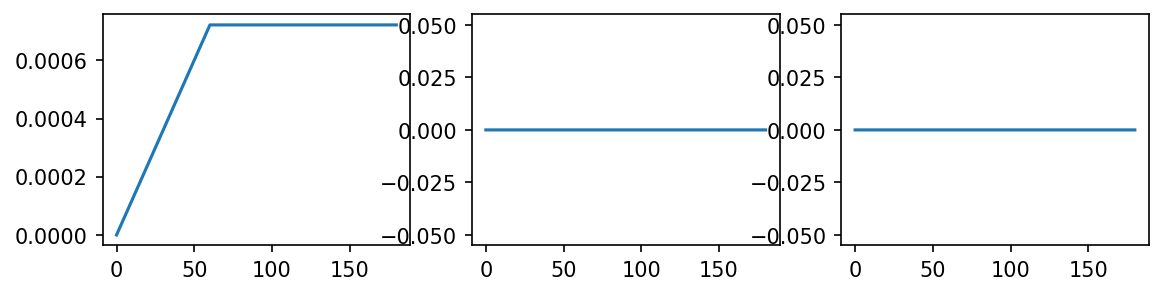

In [46]:
trj_raw = trj = pd.read_csv("../data/trj.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/ctrj.csv", index_col=[0,1])

fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax[0].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax[1].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax[2].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))


## Trajectories sanity check

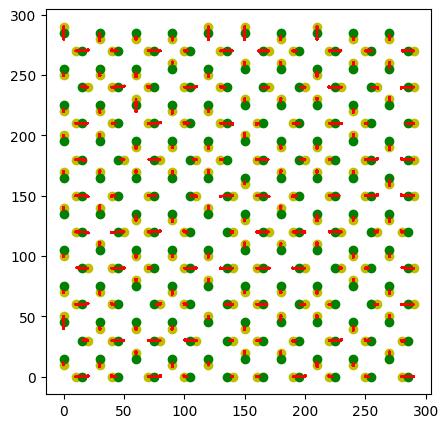

In [47]:
f,ax = plotColloid(trj_raw,0);
for i, trj_i in trj_raw.groupby("id"):
    if all(trj_i.type==1):
        ax.plot(np.array(trj_i.x),np.array(trj_i.y), color = "r")

## Vertex Charges

In [ ]:
path = "../data/test3/paintedFrames/"
frames = trj.index.get_level_values("frame").unique().to_list();
frames = frames[:];
saveAllPaintedFrames(trj_raw,ctrj_raw,
                     frames,framespersec.magnitude,
                     path);

## Producing and saving vertices file

In [ ]:
v = ice.vertices()
frames = ctrj_raw.index.get_level_values("frame").unique()

#v.trj_to_vertices(ctrj_raw.loc[frames[::100]])
v.trj_to_vertices(ctrj_raw.loc[frames[:]])
v.vertices.to_csv('../data/vertices.csv')

## Loading vertices and counting

In [ ]:
vertices = pd.read_csv("../data/vertices.csv", index_col=[0,1])
vertices = classify_vertices(vertices)
vertices = vertices.dropna()

count = ice.count_vertices(vertices)
for vertexType,v_t in count.groupby("type"):
    plotTime = np.array(v_t.index.get_level_values('frame')) / framespersec
    vertexFraction = np.array(v_t.fraction)
    plt.plot(plotTime, vertexFraction, label = vertexType)
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('fraction of vertices')